<a href="https://colab.research.google.com/github/michaelprinc/Python/blob/master/RBI_task_v_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 6.7 MB/s eta 0:00:00


In [2]:
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Change the current working directory
os.chdir('/content/drive/My Drive/Colab Notebooks')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import warnings

In [4]:
import re
def clean_value(x):
    if isinstance(x, str):  # checks if 'x' is a string
        # Remove non-numeric characters but keep the comma
        x = re.sub(r'[^0-9,]+', '', x)
        # Replace comma with dot
        x = x.replace(',', '.')
    return x


In [5]:
# Collection of preprocessing steps
def preprocessing_collection (data):
    try:
        # Map the values
        target_mapping = {"Y": 1, "N": 0}
        data['target'] = data['Mortgage_YN'].map(target_mapping)
    except:
        pass

    try:
        # Optionally, if you want to drop the original target column, you can use:
        data = data.drop(columns=['Mortgage_YN'])
    except:
        pass

    try:
        # Let's assume that Cocunut is the ID that will not have the same explanatory power in the following estimation. # Line was updated after the initial base line model and feature analysis in the CSV file
        data = data.drop(columns=['Cocunut'])
    except:
        pass

    try:
        # condition where target is 1
        condition_target_1 = (data['target'] == 1)
    except:
        pass

    try:
        # condition where target is 0 and 'AGE_AT_ORIGINATION' is not null
        condition_target_0_age_not_null = (data['target'] == 0) & (data['AGE_AT_ORIGINATION'].notnull())
    except:
        pass

    try:
        # If there's a value in 'AGE_AT_ORIGINATION' when the target is 0, print a warning
        if data[condition_target_0_age_not_null].shape[0] > 0:
            warnings.warn("There are values in 'AGE_AT_ORIGINATION' when target is 0.")
    except:
        pass

    try:
        # Replace 'AGE' with 'AGE_AT_ORIGINATION' where target is 1
        data.loc[condition_target_1, 'AGE'] = data.loc[condition_target_1, 'AGE_AT_ORIGINATION']
    except:
        pass

    try:
        # Drop the 'AGE_AT_ORIGINATION' column
        data = data.drop(columns=['AGE_AT_ORIGINATION'])
    except:
        pass

    for col in ['CURRENT_BALANCE_EUR', 'CUST_INCOME', 'CURRENT_ADDRESS_DATE',	'CURRENT_JOB_DATE',	'CURRENT_WITH_BANK_DATE'] :
        # Try to convert column to numeric
        try:
            # Make a copy of the column
            temp_column = data[col].copy()

            # Apply the function to each element of the column
            temp_column = temp_column.apply(clean_value)

            # Now convert to numeric
            temp_column = pd.to_numeric(temp_column, errors='coerce')

            # If no exception was raised, assign the transformed column back to the dataframe
            data[col] = temp_column
        except:
            print("An error occurred")
    # Identify numerical and categorical columns
    num_cols = data.select_dtypes(include=np.number).columns.tolist()
    cat_cols = data.select_dtypes(exclude=np.number).columns.tolist()

    # Outlier analysis using IQR for numerical columns
    for col in num_cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5*IQR
        upper_limit = Q3 + 1.5*IQR
        outliers = data[(data[col]<lower_limit)|(data[col]>upper_limit)]
        print(f"{col} has {outliers.shape[0]} outliers.")

    return data

In [6]:
# Load the dataset
data = pd.read_csv("Retail data.csv", delimiter=";")
data

,Cocunut,Mortgage_YN,AGE_AT_ORIGINATION,AGE,YEARS_WITH_BANK,MARTIAL_STATUS,EDUCATION,EMPLOYMENT,GENDER,CUST_INCOME,CURRENT_ADDRESS_DATE,CURRENT_JOB_DATE,CURRENT_WITH_BANK_DATE,CURRENT_BALANCE_EUR
0,1,Y,50.0,52,13,M,HGH,PVE,M,"909,5013077",1979-04-18,2010-01-01,2004-03-16,"7648,350692"
1,9,Y,48.0,49,11,M,HGH,SFE,M,"288,4615385",1999-12-16,2004-01-20,2005-11-07,"30189,90492"
2,11,Y,53.0,55,14,M,BCR,STE,M,"1280,528692",2005-06-28,1990-09-01,2003-06-25,"50553,17454"
3,12,Y,64.0,66,10,M,BCR,OTH,F,"620,9597692",2000-12-22,9999-10-01,2006-12-21,"15907,28338"
4,18,Y,46.0,47,9,S,MAS,PVE,F,"2239,853846",2009-08-01,2013-12-24,2007-08-07,"27916,19262"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23978,79979,N,NaN,67,3,M,BCR,RET,M,"179,2163077",1999-03-10,9999-10-01,2014-06-02,"781,19"
23979,79982,N,NaN,59,13,M,HGH,PVE,F,"690,0951538",1997-01-01,2004-01-01,2004-01-12,"13716,36638"
23980,79983,N,NaN,68,7,W,PRS,RET,M,"255,9498462",1949-10-27,9999-10-01,2009-12-01,"1066,28"
23981,79985,N,NaN,59,2,M,BCR,STE,M,"459,3230769",2003-04-01,2008-09-24,2015-04-23,"4577,400385"


In [7]:
# Preprocess data
data = preprocessing_collection(data)

# Identify numerical and categorical columns
num_cols = data.select_dtypes(include=np.number).columns.tolist()
cat_cols = data.select_dtypes(exclude=np.number).columns.tolist()


AGE has 2 outliers.
YEARS_WITH_BANK has 1 outliers.
CUST_INCOME has 1927 outliers.
CURRENT_ADDRESS_DATE has 228 outliers.
CURRENT_JOB_DATE has 6375 outliers.
CURRENT_WITH_BANK_DATE has 1 outliers.
CURRENT_BALANCE_EUR has 1680 outliers.
target has 306 outliers.


In [8]:
data

,AGE,YEARS_WITH_BANK,MARTIAL_STATUS,EDUCATION,EMPLOYMENT,GENDER,CUST_INCOME,CURRENT_ADDRESS_DATE,CURRENT_JOB_DATE,CURRENT_WITH_BANK_DATE,CURRENT_BALANCE_EUR,target
0,50,13,M,HGH,PVE,M,909.501308,19790418,20100101,20040316,7648.350692,1
1,48,11,M,HGH,SFE,M,288.461539,19991216,20040120,20051107,30189.904920,1
2,53,14,M,BCR,STE,M,1280.528692,20050628,19900901,20030625,50553.174540,1
3,64,10,M,BCR,OTH,F,620.959769,20001222,99991001,20061221,15907.283380,1
4,46,9,S,MAS,PVE,F,2239.853846,20090801,20131224,20070807,27916.192620,1
...,...,...,...,...,...,...,...,...,...,...,...,...
23978,67,3,M,BCR,RET,M,179.216308,19990310,99991001,20140602,781.190000,0
23979,59,13,M,HGH,PVE,F,690.095154,19970101,20040101,20040112,13716.366380,0
23980,68,7,W,PRS,RET,M,255.949846,19491027,99991001,20091201,1066.280000,0
23981,59,2,M,BCR,STE,M,459.323077,20030401,20080924,20150423,4577.400385,0


<ipython-input-9-e239c1d98f05>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = data.corr()


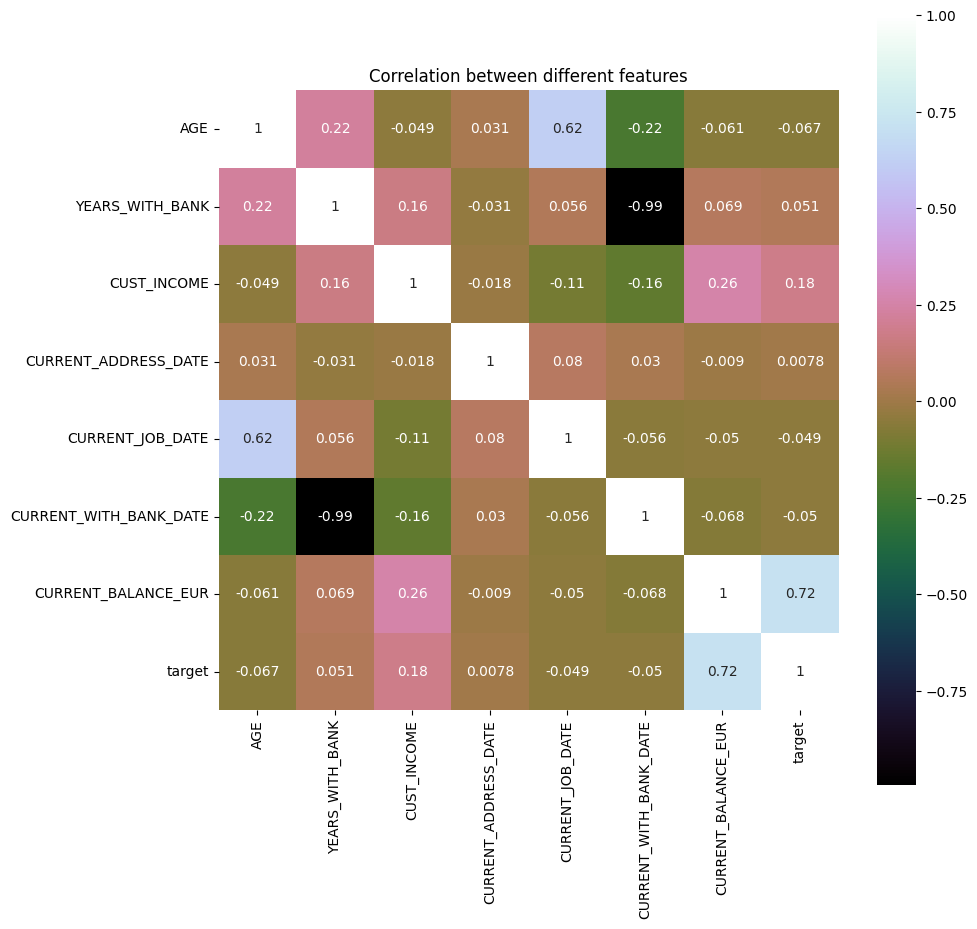

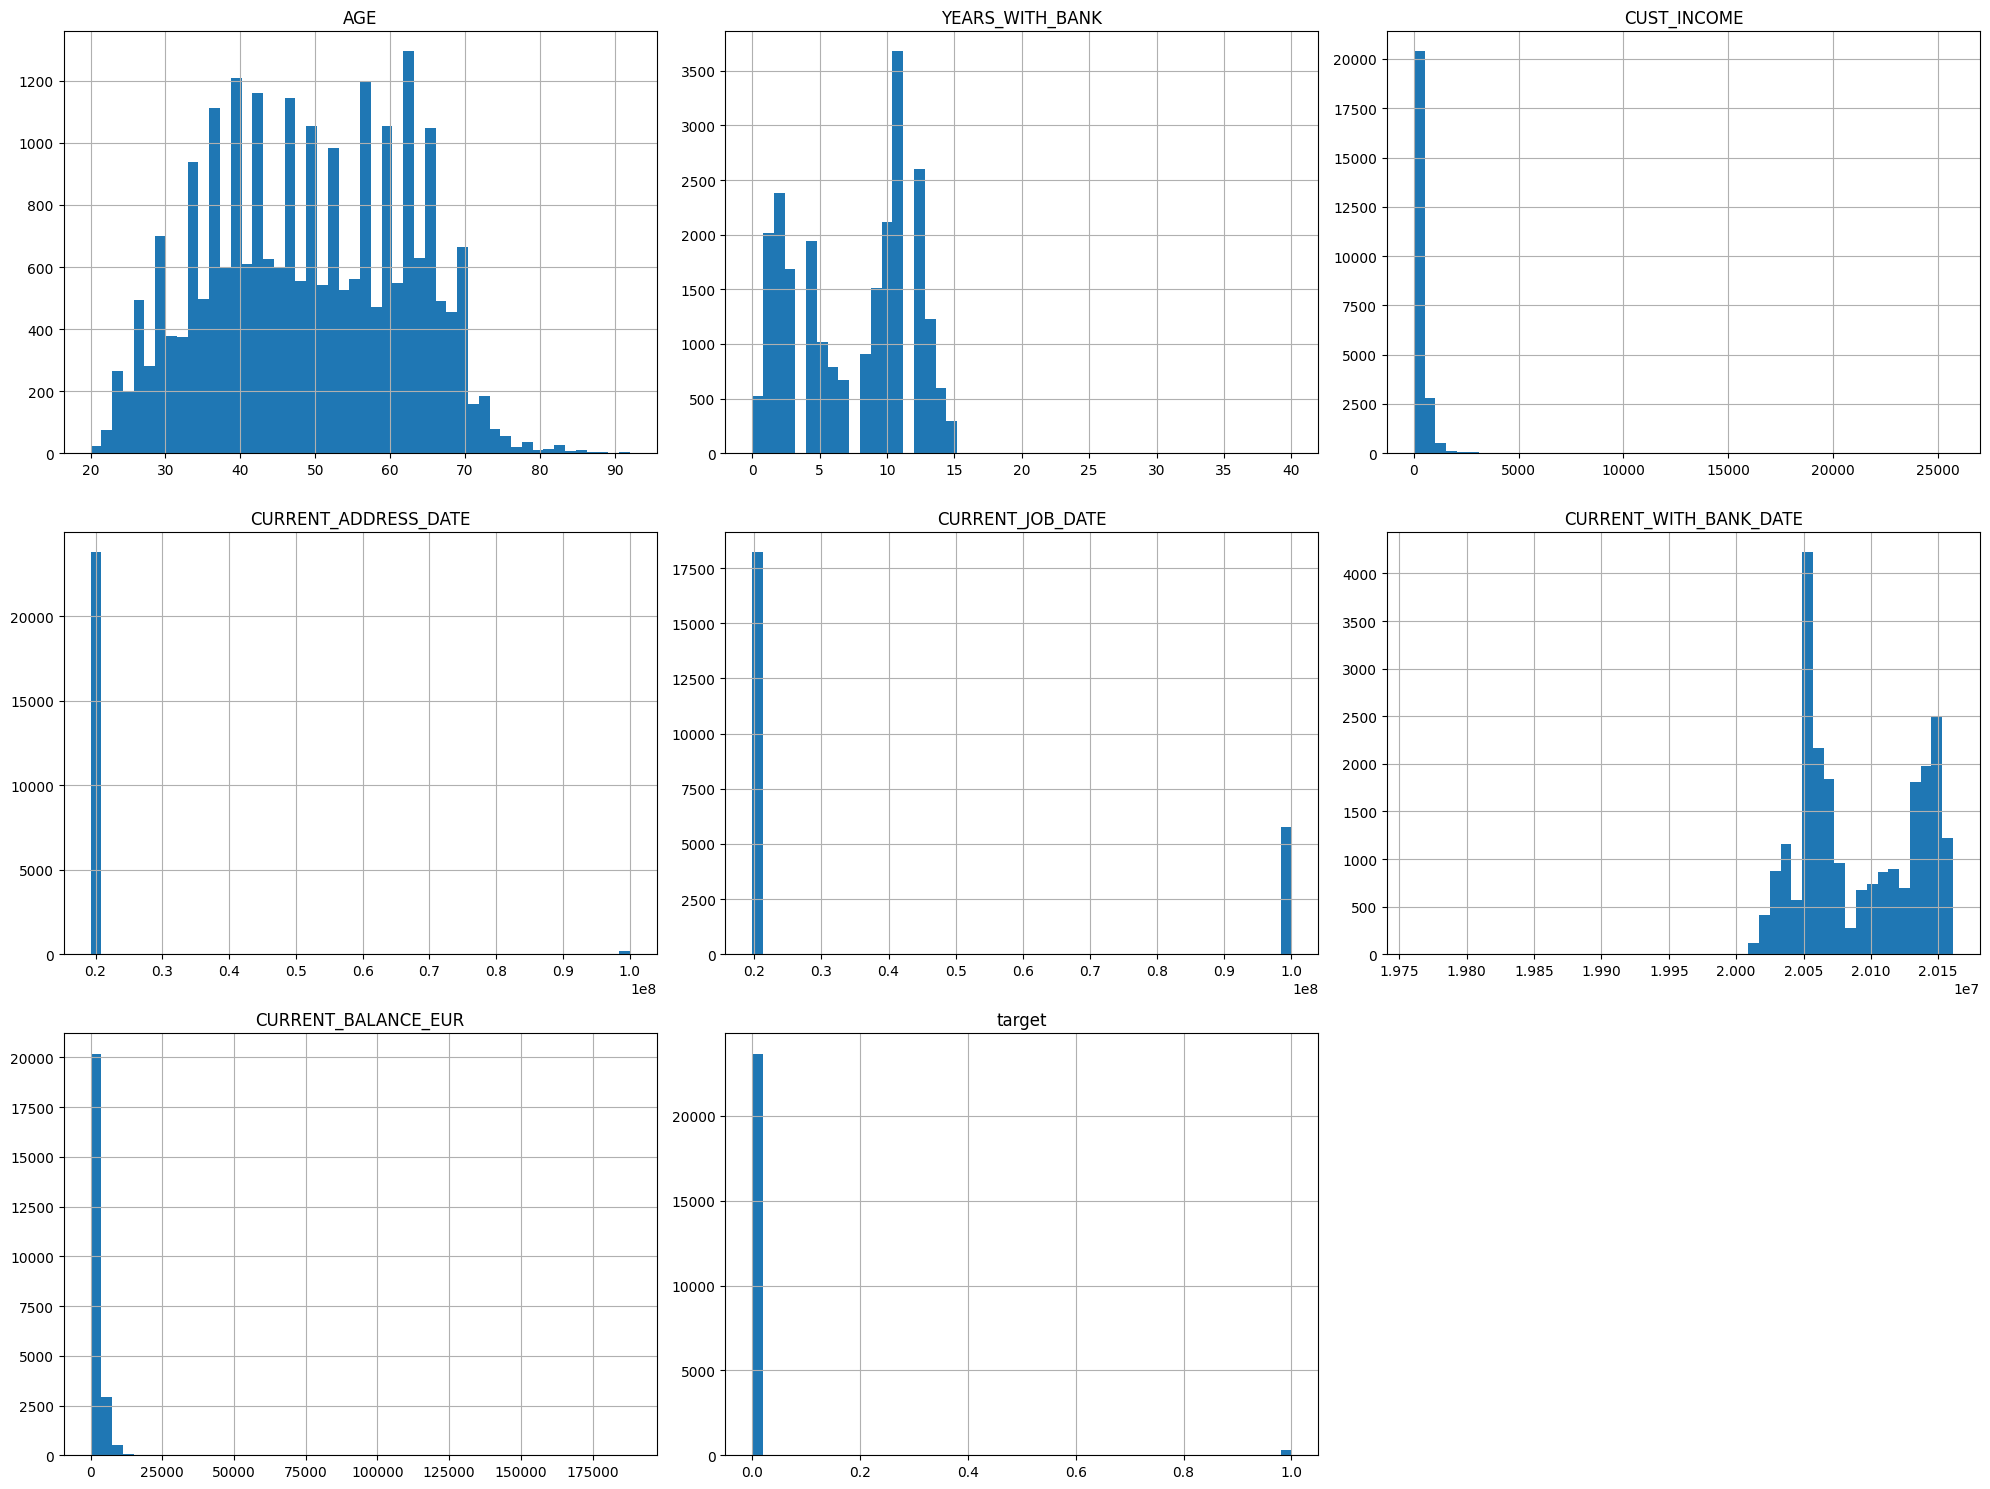

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation Matrix
correlation = data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')
plt.title('Correlation between different features')
plt.show()
plt.savefig('correlation_matrix.png')


# Histograms
data.hist(bins=50, figsize=(20,15))
plt.tight_layout()  # improves appearance a bit.
plt.show()
plt.savefig('histograms.png')


In [10]:
# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Separating predictors and target
X_train = train_data.drop("target", axis=1)
y_train = train_data["target"]
X_test = test_data.drop("target", axis=1)
y_test = test_data["target"]

In [11]:
from sklearn.preprocessing import LabelEncoder

class ModifiedLabelEncoder(LabelEncoder):
    def transform(self, y):
        unseen_mask = ~(np.isin(y, self.classes_))
        y[unseen_mask] = 'rare_values_and_unknown_values'
        return super().transform(y)
    def fit_transform(self, y, *args, **kwargs):
        return super().fit_transform(np.where(y.isin(y.value_counts().index[y.value_counts() < 10]), 'rare_values_and_unknown_values', y))

# Loop over the categorical columns and apply the modified label encoder
le = ModifiedLabelEncoder()

for col in cat_cols:
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])


# Hyperopt parameter tuning setup
def objective(space):
    clf = CatBoostClassifier(iterations = space['iterations'],
                              depth = int(space['depth']),
                              learning_rate = space['learning_rate'],
                              l2_leaf_reg = space['l2_leaf_reg'],
                              border_count = int(space['border_count']),
                              loss_function='Logloss',
                              verbose=False)
    evaluation = cross_val_score(clf, X_train, y_train, cv=5).mean()



    return{'loss': 1-evaluation, 'status': STATUS_OK }

# Parameter space
space ={
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'iterations': hp.quniform('iterations', 50, 300, 1),
    'depth': hp.quniform('depth', 2, 8, 1),
    'l2_leaf_reg': hp.quniform('l2_leaf_reg', 1, 10, 1),
    'border_count': hp.quniform('border_count', 5, 255, 5),
}

# Run the hyperparameter search using TPE
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

<ipython-input-11-fcac5d89d1b4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[unseen_mask] = 'rare_values_and_unknown_values'
<ipython-input-11-fcac5d89d1b4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[unseen_mask] = 'rare_values_and_unknown_values'
<ipython-input-11-fcac5d89d1b4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[unseen_mask] = 'rare_values_and_unknown_values'
<ipython-input-11-fcac5d89d1b4>:6: SettingWith

100%|██████████| 50/50 [03:47<00:00,  4.55s/trial, best loss: 0.0022933362016501757]


In [12]:
# Assuming you have a pandas dataframe 'data'
for col in data.columns:
    # Check if number of unique values is more than half the total number of observations
    if len(data[col].unique()) > len(data)/2:
        print(f'Feature {col} might be behaving like an ID')

    # Check if feature has only one unique value
    if len(data[col].unique()) == 1:
        print(f'Feature {col} has zero variance')

Feature CUST_INCOME might be behaving like an ID
Feature CURRENT_BALANCE_EUR might be behaving like an ID


In [13]:
best_hyperparams

{'border_count': 240.0,
 'depth': 5.0,
 'iterations': 73.0,
 'l2_leaf_reg': 6.0,
 'learning_rate': 0.42}

In [14]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import joblib
import matplotlib.pyplot as plt
import numpy as np

In [15]:
# Load the trained model
model = joblib.load('catboost_model.pkl')

In [16]:
cat_cols # CURRENT_BALANCE_EUR and CUST_INCOME can be numerical

['MARTIAL_STATUS', 'EDUCATION', 'EMPLOYMENT', 'GENDER']

ROC AUC score:  0.9951156089676014
Confusion Matrix: 
 [[4706   37]
 [   3   51]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      4743
           1       0.58      0.94      0.72        54

    accuracy                           0.99      4797
   macro avg       0.79      0.97      0.86      4797
weighted avg       0.99      0.99      0.99      4797



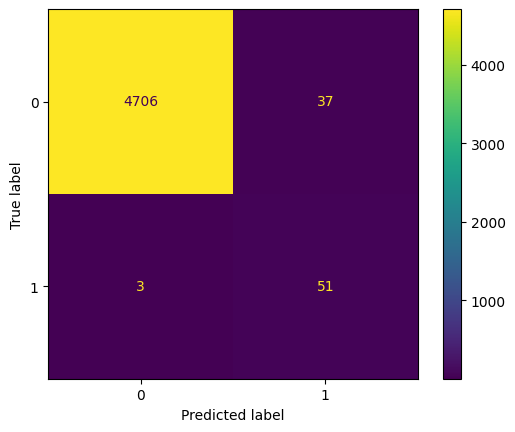

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

# Train CatBoost with the best hyperparameters
model = CatBoostClassifier(
    **best_hyperparams,
    auto_class_weights='Balanced',
    cat_features=cat_cols,
    verbose=0
)
model.fit(X_train, y_train)

# Save the trained model
joblib.dump(model, 'catboost_model.pkl')

# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Model evaluation
print("ROC AUC score: ", roc_auc_score(y_test, y_proba))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=model.classes_)
disp.plot()

# plot_confusion_matrix
plt.savefig('confusion_matrix.png')


In [18]:
# Save the trained model
joblib.dump(model, 'catboost_model.pkl')


['catboost_model.pkl']

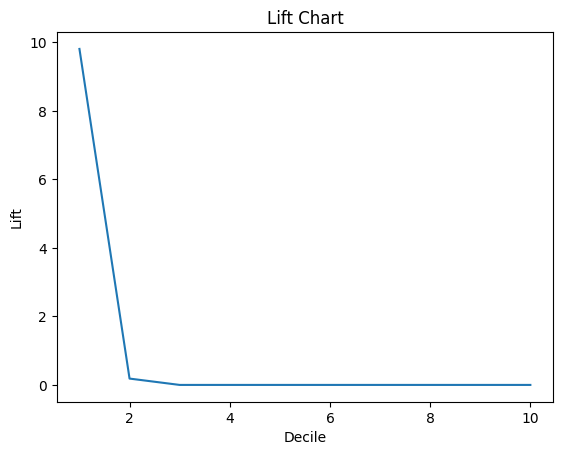

<Figure size 640x480 with 0 Axes>

In [19]:

# Calculate decile-wise lift
df = pd.DataFrame({"target": y_test, "pred_prob": y_proba})
df["decile"] = pd.qcut(df["pred_prob"], 10, labels=np.arange(10, 0, -1))
lift_df = df.groupby("decile")["target"].mean() / df["target"].mean()
lift_df = lift_df.reset_index()

plt.plot(lift_df["decile"], lift_df["target"])
plt.xlabel("Decile")
plt.ylabel("Lift")
plt.title("Lift Chart")
plt.show()
plt.savefig('lift.png')


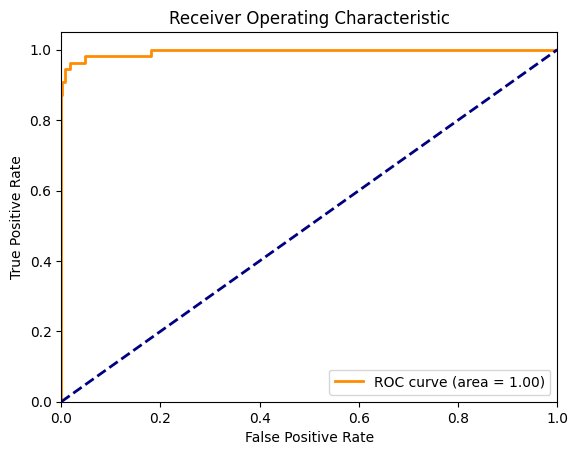

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have your true labels in y_test and predicted probabilities in y_proba
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')

In [21]:
# !pip install sklearn

In [22]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 9.7 MB/s eta 0:00:00


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


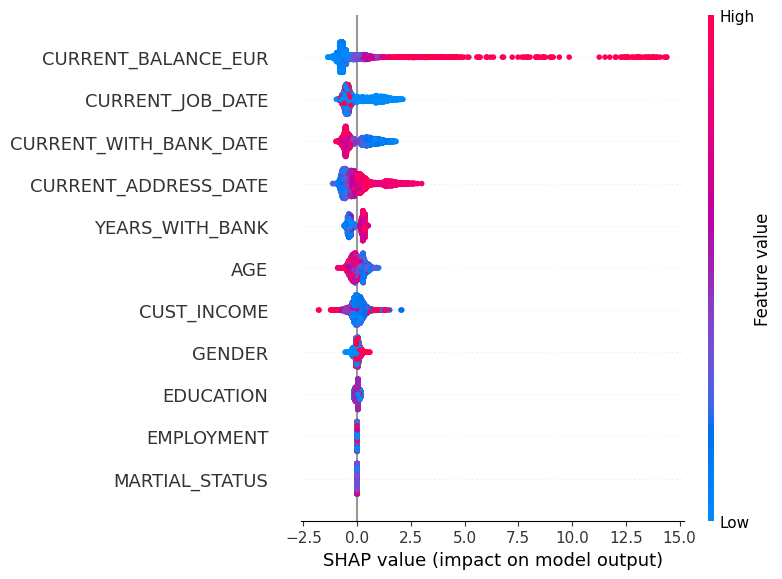

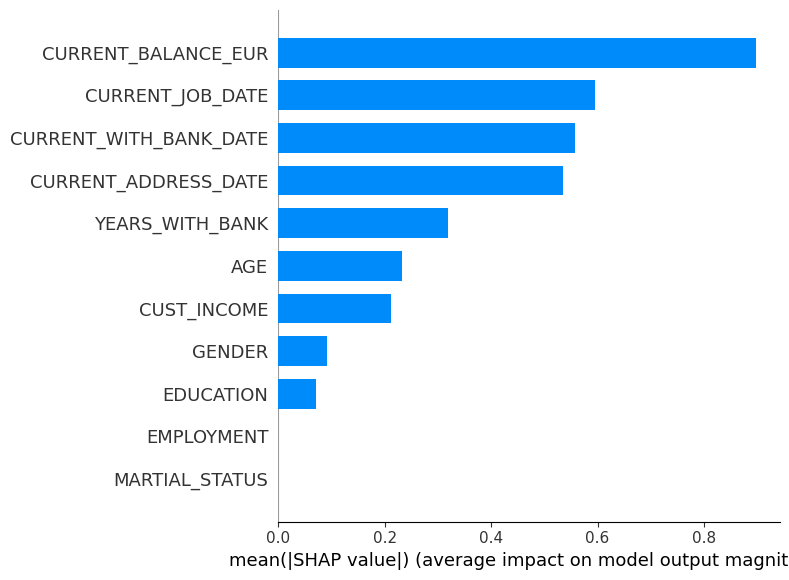

In [23]:
import shap
import matplotlib.pyplot as plt

# load the model
model = joblib.load('catboost_model.pkl')

# Initialize JavaScript visualization code for SHAP
shap.initjs()

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# summarize the effects of all the features
shap.summary_plot(shap_values, X_test)

# We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [24]:
!pip install python-pptx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 59.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 17.3 MB/s eta 0:00:00
  Created wheel for python-pptx: filename=python_pptx-0.6.21-py3-none-any.whl size=470935 sha256=d2b636d08fe034a89c436de1cf7fc4e5494717a4912093f50713797f850daba6
  Stored in directory: /root/.cache/pip/wheels/ea/dd/74/01b3ec7256a0800b99384e9a0f7620e358afc3a51a59bf9b49
Successfully built python-pptx


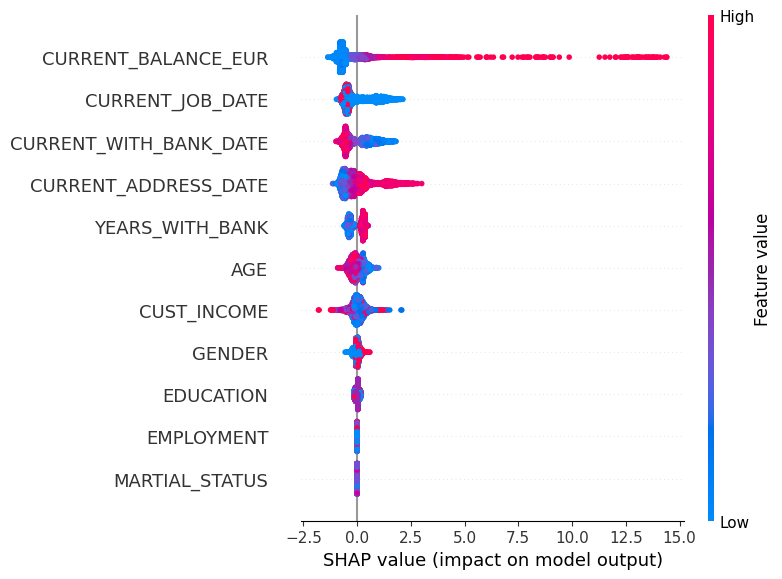

<Figure size 640x480 with 0 Axes>

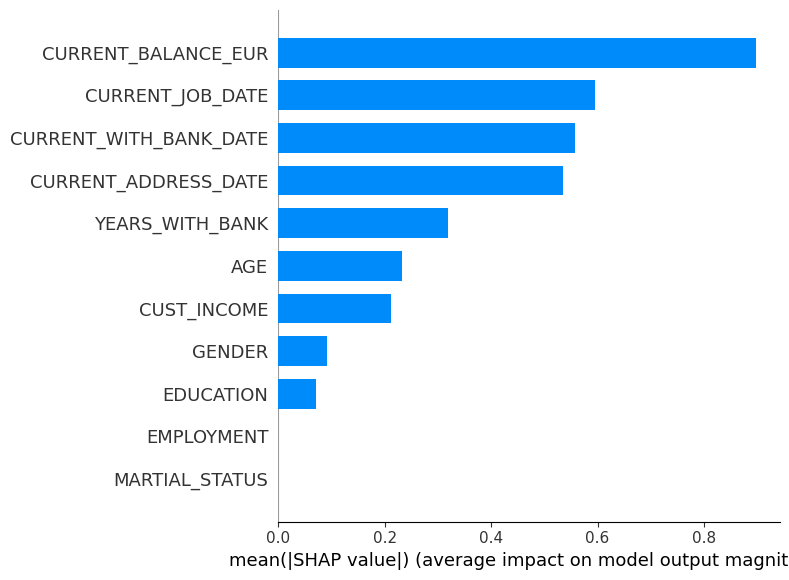

<Figure size 640x480 with 0 Axes>

In [25]:
import shap
import matplotlib.pyplot as plt
from pptx import Presentation
from pptx.util import Inches

# Initialize JavaScript visualization code for SHAP
shap.initjs()

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# summarize the effects of all the features
plt.figure()
shap.summary_plot(shap_values, X_test)
plt.savefig('summary_plot.png')  # save the figure to file

# We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs):
plt.figure()
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.savefig('bar_plot.png')  # save the figure to file

# Create a presentation object
prs = Presentation()

# Define slide layout. 5 is for a slide with title and content
slide_layout = prs.slide_layouts[5]

# Add a slide with the above layout
slide = prs.slides.add_slide(slide_layout)

# Add a title
title = slide.shapes.title
title.text = "My SHAP Analysis"

# Add summary_plot image
img_path = 'summary_plot.png'  # use the path where you saved your plot image

# Define the position and size of the image
left = Inches(1)
top = Inches(1)
width = Inches(6)
height = Inches(4.5)

# Add the image to the slide
pic = slide.shapes.add_picture(img_path, left, top, width, height)

# Add a new slide for the bar plot
slide = prs.slides.add_slide(slide_layout)

# Add a title
title = slide.shapes.title
title.text = "My SHAP Analysis: Bar Plot"

# Add bar_plot image
img_path = 'bar_plot.png'  # use the path where you saved your plot image

# Define the position and size of the image
left = Inches(1)
top = Inches(1)
width = Inches(6)
height = Inches(4.5)

# Add the image to the slide
pic = slide.shapes.add_picture(img_path, left, top, width, height)

# Save the presentation
prs.save('my_presentation.pptx')


In [26]:
### Prediction part

data_for_prediction = pd.read_csv("Potential Customers.csv", delimiter=";")

data_for_prediction = preprocessing_collection(data_for_prediction)

AGE has 0 outliers.
YEARS_WITH_BANK has 0 outliers.
CUST_INCOME has 214 outliers.
CURRENT_ADDRESS_DATE has 61 outliers.
CURRENT_JOB_DATE has 0 outliers.
CURRENT_WITH_BANK_DATE has 0 outliers.
CURRENT_BALANCE_EUR has 30 outliers.


In [27]:
new_pred = model.predict(data_for_prediction)

In [28]:
new_pred

array([0, 0, 0, ..., 0, 0, 0])

In [29]:
data_with_prediction = data_for_prediction.copy()
data_with_prediction['Model_Mortgage Prediction'] = new_pred

In [30]:
data_with_prediction['Model_Mortgage Prediction'].sum()

59